In [1]:
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [2]:
## 読み込み
df_train = pd.read_csv("../data/train_set.csv", low_memory=False)
df_test = pd.read_csv("../data/test_set.csv", low_memory=False)

In [3]:
## xの前処理を定義
def data_x_preprocessor(df_train, df_test, num_var=None, cat_var=None):
    df_x = pd.concat([df_train, df_test], axis=0)
    df_x = pd.concat([df_x[num_var], pd.get_dummies(df_x[cat_var])], axis=1)
    df_train_x = df_x.iloc[:df_train.shape[0],:]
    df_test_x  = df_x.iloc[df_train.shape[0]:,:]
    return df_train_x, df_test_x

In [4]:
## 学習＆予測
def train_and_predict(x_train, y_train, x_test):
    clf = xgb.XGBRegressor(
        learning_rate=0.01,
        n_estimators=100,
        max_depth=6
    )
    ## 学習
    clf.fit(x_train, np.log(y_train))
    ## 予測
    y_pred = clf.predict(x_test)
    return clf, y_pred

In [5]:
## xの準備
num_var = ["BATHRM", "EYB", "LONGITUDE", "FIREPLACES", "SALE_NUM", "CMPLX_NUM", "CENSUS_TRACT", "LIVING_GBA"]
cat_var = ["QUADRANT", "CNDTN", "WARD", "AC", "QUALIFIED"]
df_train_x, df_test_x = data_x_preprocessor(df_train.iloc[:,:-1], df_test, 
                                            num_var=num_var, cat_var=cat_var)

## yの準備
df_train_y = df_train[["PRICE"]]

In [6]:
#### 検証用のやつ
## 検証用にデータを準備
x_train, x_valid, y_train, y_valid = train_test_split(df_train_x, df_train_y,
                                                      test_size=0.2, random_state=123)

## 予測
clf_valid, y_pred = train_and_predict(x_train, y_train, x_valid)

## 結果
mse = mean_squared_error(y_pred, np.log(y_valid))
# mse
print("MSE", mse)
# 比較
df_valid_pred = pd.DataFrame(np.exp(y_pred), index=x_valid.index, columns=["PRED"])
display(pd.concat([y_valid.astype(int), df_valid_pred.astype(int)], axis=1).head(20))

MSE 20.90408703632712


,PRICE,PRED
21064,420000,2755
8550,290000,5429
36352,499900,4331
16664,375000,3867
30186,300000,3727
31202,640000,3327
41033,334900,3596
36597,178000,2419
39316,89500,3327
23564,49900,2020


In [7]:
#### submit用のやつ
## 予測
clf_submit, y_submit = train_and_predict(df_train_x, df_train_y, df_test_x)

## 保存
df_submit = pd.DataFrame(np.exp(y_submit), index=df_test["Id"], columns=["PRICE"])
df_submit.to_csv("../data/submit/" + dt.now().strftime("%Y%m%d_%H%M%S") + ".csv", header=True, index_label="Id")

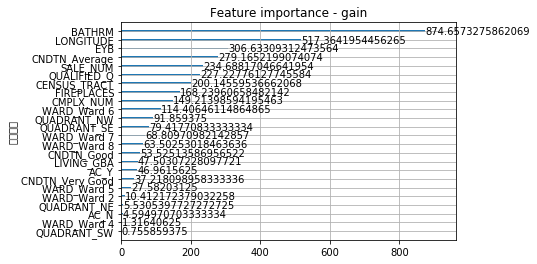

In [8]:
xgb.plot_importance(
    clf_submit,
    importance_type='gain',
    title="Feature importance - gain",
    xlabel=None,
    ylabel="説明変数",
    max_num_features=30
)